## Colin's active development sandbox

In [1]:
from enum import Enum
from pathlib import Path
import logging
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import re
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math
from concurrent.futures import ProcessPoolExecutor, as_completed
from DataPreProcessing import DataPreProcessing, DataPaths
from DataAugmentation import DataAugmentation

### Tracklet iterator

[2025-02-26 21:24:47] - [INFO]: DataPreProcessing initialized.
[2025-02-26 21:24:47] - [INFO]: ROOT_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted
[2025-02-26 21:24:47] - [INFO]: TRAIN_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\train\images
[2025-02-26 21:24:47] - [INFO]: TEST_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\test\images
[2025-02-26 21:24:47] - [INFO]: VAL_DATA_DIR: c:\Users\colin\OneDrive\Desktop\UBC\Jersey-Number-Recognition\data\SoccerNet\jersey-2023\extracted\challenge\images
[2025-02-26 21:24:47] - [INFO]: Using device: cuda
[2025-02-26 21:24:47] - [INFO]: ['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005']
[2025-02-26 21:24:47] - [INFO]: Min tracklet: 0
[2025-02-26 21:24:47] - [INFO]: Max tracklet: 1426


Processing tracks:   0%|          | 0/1 [00:00<?, ?it/s]

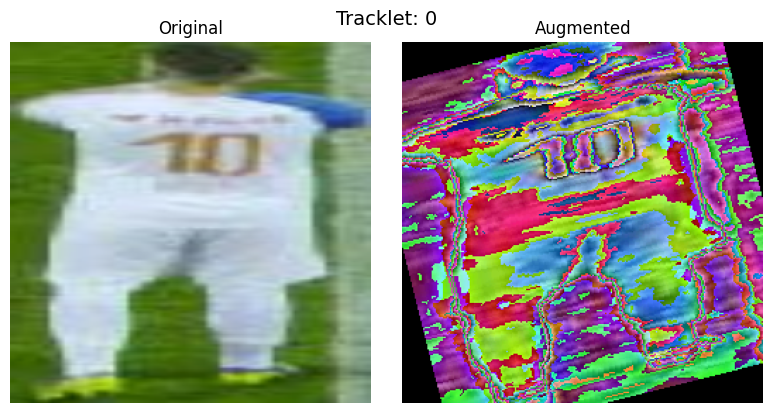

In [2]:
import math
import matplotlib.pyplot as plt
import torch
from DataPreProcessing import DataPreProcessing, DataPaths
from DataAugmentation import DataAugmentation  # assuming your DataAugmentation class is defined in DataAugmentation.py
import logging

input_folder = DataPaths.TRAIN_DATA_DIR.value

NUM_TRACKLETS = 1
NUM_IMGS_PER_TRACKLET = 1

# Instantiate the pre-processing class and load data
data_pre = DataPreProcessing()
data_dict = data_pre.generate_features(input_folder, DataPaths.TEMP_EXPERIMENT_DIR.value, num_tracks=NUM_TRACKLETS)

# Instantiate the augmentor and augment the data using specific transformations
augmentor = DataAugmentation(data_dict)
# Here, we choose to apply "rotation" and "contrast" augmentations.
augmented_data = augmentor.augment_data(["rotation", "contrast"])

selected_tracks = list(data_dict.keys())[:NUM_TRACKLETS]

# For each tracklet, display each image with its augmented version side by side.
for track in selected_tracks:
    # Get original images (up to NUM_IMGS_PER_TRACKLET) for the tracklet.
    orig_tensor = data_dict[track][:NUM_IMGS_PER_TRACKLET]  # shape: (N, C, H, W)
    # Get the corresponding augmented results (each is a dict mapping augmentation types to tensors)
    aug_list = augmented_data[track][:NUM_IMGS_PER_TRACKLET]
    num_images = orig_tensor.shape[0]
    
    # Create a figure with num_images rows and 2 columns (Original, Augmented)
    fig, axs = plt.subplots(num_images, 2, figsize=(8, num_images * 4))
    if num_images == 1:
        axs = [axs]  # Ensure we can iterate over rows
    
    for i in range(num_images):
        # Process original image
        orig_img = orig_tensor[i].permute(1, 2, 0).numpy()
        orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-6)
        axs[i][0].imshow(orig_img)
        axs[i][0].set_title("Original")
        axs[i][0].axis("off")
        
        # Choose an augmented version: try "rotation" first, then "contrast", then any available.
        aug_dict = aug_list[i]
        if "rotation" in aug_dict:
            aug_img_tensor = aug_dict["rotation"]
        elif "contrast" in aug_dict:
            aug_img_tensor = aug_dict["contrast"]
        else:
            # Pick the first augmentation that is not 'original'
            keys = [k for k in aug_dict.keys() if k != "original"]
            aug_img_tensor = aug_dict[keys[0]] if keys else aug_dict["original"]
        
        aug_img = aug_img_tensor.permute(1, 2, 0).numpy()
        aug_img = (aug_img - aug_img.min()) / (aug_img.max() - aug_img.min() + 1e-6)
        axs[i][1].imshow(aug_img)
        axs[i][1].set_title("Augmented")
        axs[i][1].axis("off")
    
    plt.tight_layout()
    plt.suptitle(f"Tracklet: {track}", fontsize=14, y=1.02)
    plt.show()
